In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(1)

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [3]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=600, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

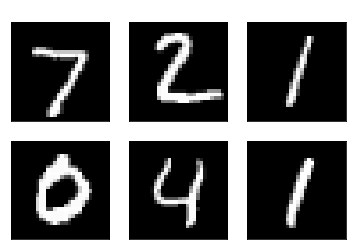

In [4]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title("Actual Val: {}".format(example_targets[i]),color='white')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [5]:
class CNN1(nn.Module):
    def __init__(self,):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size) #1st Convolution
        self.pool = nn.MaxPool2d(2, 2)   #pool_size=2, strides=2 
        self.conv2 = nn.Conv2d(10, 20, kernel_size) #2nd Convolution
        self.fc1 = nn.Linear(320, 50) #((I/P - Filter + 2*Pad)/Stride)+1 
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 320)            #Flattening 
        x = F.relu(self.fc1(x))        #Fully Connected NN   
        x = self.dropout(x)   
        x = F.relu(self.fc2(x))        #Fully Connected NN           
        x = self.fc3(x)                #O/P Layer       
        return x

In [6]:
# train_losses = []
# train_epoch = []
# train_acc = []
# test_losses = []
# test_epoch = []
# not_converged =True
# epoch = 0
# Train the model

#for epoch in range(num_epochs):
def trainFunc(model,num_epochs):
    model.train()
    n_total_steps = len(train_loader)
    train_losses = []
    train_epoch = []
    train_acc = []
    not_converged =True
    epoch = 0
    trainAvgLossArr = []
    while not_converged:
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum = 0

        for i, (images, labels) in enumerate(train_loader):  
            # Forward pass
            prediction = model(images)
            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            if (i+1) % 100 == 0:
                print (f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end='\r',flush=True)
                train_epoch.append(epoch)
                train_losses.append(loss.item())
                print(f'Epoch [{epoch}/{num_epochs}], Accuracy : {acc} %',end='\r',flush=True)
                train_acc.append(acc)

                if epoch == num_epochs:
                        print(f"Max Epoch Reached, Loss: {loss.item():.4f}, Accuracy:{acc:2f}%")
                        not_converged = False
                elif (epoch > 5) and  (train_losses[-1] < 0.001):
                    if abs(train_losses[-3] - train_losses[-2]) < 1.0e-05 and abs(train_losses[-2] - train_losses[-1]) < 1.0e-05:
                        print("Convergeance reached for loss:",train_losses[-1])
                        not_converged = False

        trainAvgLossArr.append(lossSum/i+1)
        
                        
    return train_epoch,train_losses,train_acc,trainAvgLossArr

In [7]:
# Hyper-parameters 
input_size = 784 # 28x28
max_epochs = 15
learning_rate = 0.001
kernel_size = 4
weight_decay_val = 1e-4
dropout = 0.25

In [8]:
torch.manual_seed(1)

cnn1 = CNN1()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn1.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]
for i in cnn1.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(a),)

Total no of parameters in Model 1: 25550


In [9]:
train_epoch,train_losses,train_acc,trainAvgLossArr =trainFunc(cnn1,max_epochs)

Max Epoch Reached, Loss: 0.0744, Accuracy:98.045000%


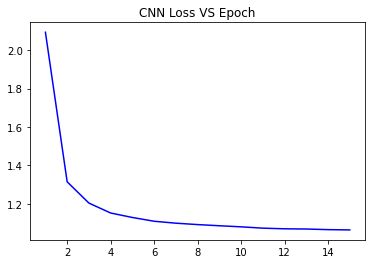

In [10]:
#plot
plt.plot(train_epoch,trainAvgLossArr,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()

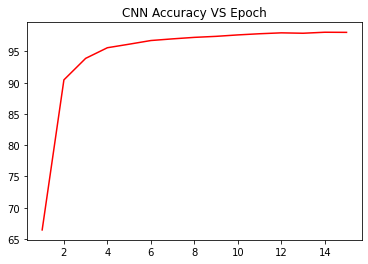

In [11]:
#plot
plt.plot(train_epoch,train_acc,color="red")
plt.title('CNN Accuracy VS Epoch')
plt.show()

In [12]:
def testFunc (model):
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for test_images, test_labels in test_loader:
            outputs = model(test_images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += test_labels.size(0)
            n_correct += (predicted == test_labels).sum().item()
            
            for i in range(100):
                label = test_labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        netTest_acc1 = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {netTest_acc1} %')

        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {i}: {acc} %')
    
    return netTest_acc1

In [13]:
cnn1TestAcc = testFunc(cnn1)

Accuracy of the network: 98.66 %
Accuracy of 0: 99.48979591836735 %
Accuracy of 1: 99.29515418502203 %
Accuracy of 2: 98.25581395348837 %
Accuracy of 3: 98.41584158415841 %
Accuracy of 4: 99.38900203665987 %
Accuracy of 5: 98.99103139013452 %
Accuracy of 6: 98.43423799582463 %
Accuracy of 7: 99.0272373540856 %
Accuracy of 8: 97.84394250513347 %
Accuracy of 9: 97.42319127849356 %


In [14]:
class CNN2(nn.Module):
    def __init__(self,):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size) #1st Convolution
        self.pool = nn.MaxPool2d(2, 2)   #pool_size=2, strides=2 
        self.conv2 = nn.Conv2d(10, 20, kernel_size) #2nd Convolution
        self.fc1 = nn.Linear(20*kernel_size*kernel_size, 50) #((I/P - Filter + 2*Pad)/Stride)+1 
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,40)
        self.fc4 = nn.Linear(40,30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 320)            #Flattening 
        x = F.relu(self.fc1(x))        #Fully Connected NN       
        x = F.relu(self.fc2(x))        #Fully Connected NN 
        x = F.relu(self.fc3(x))        #Fully Connected NN 
        x = F.relu(self.fc4(x))        #Fully Connected NN
        #x = F.relu(self.fc5(x))        #Fully Connected NN 
        x = self.fc5(x)                #O/P Layer       
        return x


In [15]:
torch.manual_seed(1)

cnn2 = CNN2()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]

for i in cnn2.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 2:', np.sum(a),)

Total no of parameters in Model 2: 25570


In [16]:
train_epoch2,train_losses2,train_acc2,trainAvgLossArr2=trainFunc(cnn2,max_epochs)

Max Epoch Reached, Loss: 0.0880, Accuracy:97.825000%


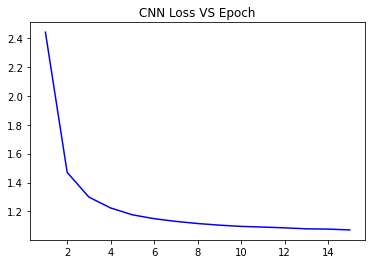

In [17]:
#plot
plt.plot(train_epoch2,trainAvgLossArr2,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()

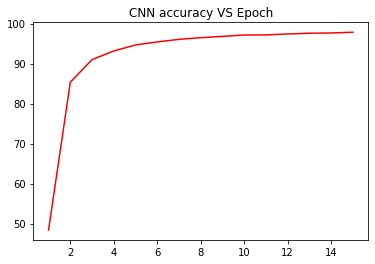

In [18]:
#plot
plt.plot(train_epoch2,train_acc2,color="red")
plt.title('CNN accuracy VS Epoch')
plt.show()

In [19]:
cnn2TestAcc = testFunc(cnn2)

Accuracy of the network: 97.9 %
Accuracy of 0: 99.28571428571429 %
Accuracy of 1: 99.20704845814979 %
Accuracy of 2: 97.96511627906976 %
Accuracy of 3: 96.83168316831683 %
Accuracy of 4: 98.57433808553971 %
Accuracy of 5: 97.98206278026906 %
Accuracy of 6: 98.43423799582463 %
Accuracy of 7: 97.95719844357977 %
Accuracy of 8: 98.04928131416838 %
Accuracy of 9: 94.64816650148661 %


In [20]:
#Model 3
class CNN3(nn.Module):
    def __init__(self,): 
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 15, 5)
        self.fc1 = nn.Linear(15*4*4, 86)
        self.fc2 = nn.Linear(86, 10)
       

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
     
        x = x.view(-1, 15*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [21]:
torch.manual_seed(1)

cnn3 = CNN3()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn3.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]

for i in cnn3.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 3:', np.sum(a))

Total no of parameters in Model 3: 25621


In [22]:
train_epoch3,train_losses3,train_acc3,trainAvgLossArr3=trainFunc(cnn3,max_epochs)

Max Epoch Reached, Loss: 0.0242, Accuracy:98.898333%


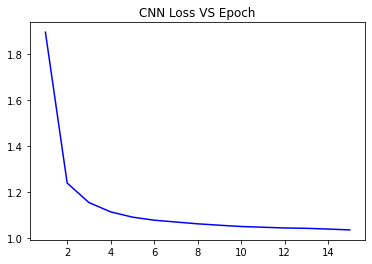

In [23]:
#plot
plt.plot(train_epoch3,trainAvgLossArr3,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()

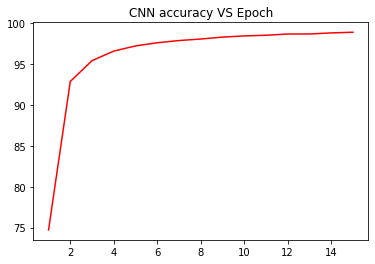

In [24]:
#plot
plt.plot(train_epoch3,train_acc3,color="red")
plt.title('CNN accuracy VS Epoch')
plt.show()

In [25]:
cnn3TestAcc = testFunc(cnn3)

Accuracy of the network: 98.8 %
Accuracy of 0: 99.48979591836735 %
Accuracy of 1: 99.20704845814979 %
Accuracy of 2: 99.2248062015504 %
Accuracy of 3: 99.00990099009901 %
Accuracy of 4: 99.38900203665987 %
Accuracy of 5: 97.6457399103139 %
Accuracy of 6: 98.95615866388309 %
Accuracy of 7: 98.44357976653697 %
Accuracy of 8: 98.870636550308 %
Accuracy of 9: 97.62140733399406 %


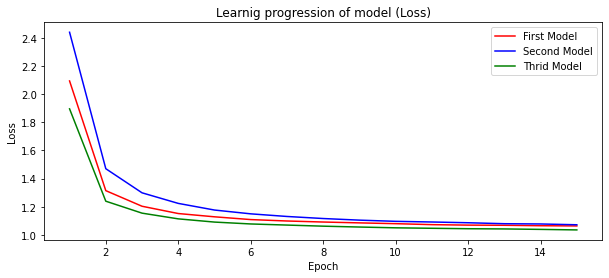

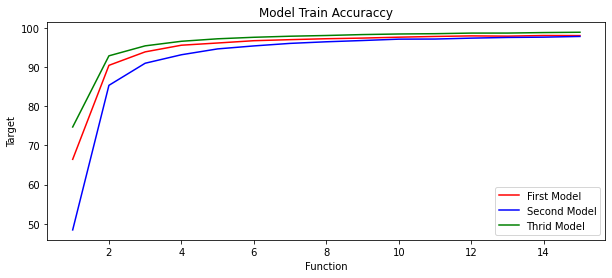

CNN1 Test Accuracy: 98.66 % 
CNN2 Test Accuracy: 97.9 % 
CNN3 Test Accuracy: 98.8 %


In [26]:
plt.figure(figsize=(10,4))
plt.plot(train_epoch,trainAvgLossArr, color = "red")
plt.plot(train_epoch2,trainAvgLossArr2, color = "blue")
plt.plot(train_epoch3,trainAvgLossArr3, color = "green")
plt.title('Learnig progression of model (Loss)')
plt.legend(['First Model', 'Second Model','Thrid Model'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('EpochVSLoss.png')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_epoch,train_acc,color="red")
plt.plot(train_epoch2,train_acc2,color="blue")
plt.plot(train_epoch3,train_acc3,color="green")
plt.title('Model Train Accuraccy')
plt.legend(['First Model', 'Second Model','Thrid Model'])
plt.xlabel('Function')
plt.ylabel('Target')
plt.savefig('Model_Prediction.png')
plt.show()

print('CNN1 Test Accuracy:',cnn1TestAcc,'%','\nCNN2 Test Accuracy:',cnn2TestAcc,'%','\nCNN3 Test Accuracy:',cnn3TestAcc,'%')